In [3]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

In [5]:
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    return

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

## Manual RNN

In [4]:
# number of neurons give the number of hidden units

reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
# the output size is the number of neurons
# thus giving output of dimension of number of neurons
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)

# here we are using the output of the previous time step
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()


In [5]:
import numpy as np

X0_batch = np.array([[0, 1, 2], 
                     [3, 4, 5], 
                     [6, 7, 8], 
                     [9, 0, 1]]) # t = 0

X1_batch = np.array([[9, 8, 7], 
                     [0, 0, 0], 
                     [6, 5, 4], 
                     [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [6]:
print(Y0_val)

[[-0.06640061  0.96257669  0.68105787  0.70918542 -0.89821595]
 [ 0.99777555 -0.71978879 -0.99657613  0.96739244 -0.99989706]
 [ 0.99999785 -0.99898809 -0.99999887  0.99677628 -0.99999988]
 [ 1.         -1.         -1.         -0.99818921  0.99950868]]


## using static_rnn()

In [8]:
n_inputs = 3
n_neurons = 5

reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
# performs the time step unrolling and learning using the cell
# unrolling means that the output of Y1 is dependent on both X1 and output of the cell
# with X0 as the input
[Y0, Y1], states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)

init = tf.global_variables_initializer()


In [9]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[-0.81393623, -0.43182847, -0.40151   ,  0.70436084,  0.89640522],
       [-0.99156624, -0.95103657,  0.1999651 ,  0.98335057,  0.99998951],
       [-0.99965042, -0.9968307 ,  0.68092692,  0.99918783,  1.        ],
       [ 0.64988363, -0.16740516,  0.99994731,  0.81680971,  0.99995035]], dtype=float32)

In [22]:
def show_graph(graph):
    summary = tf.summary.FileWriter(logdir="./log_dir/", graph=graph)
    return

In [23]:
show_graph(tf.get_default_graph())

## Packing Sequences

In [24]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [10]:
reset_graph()

# input data format totally depends on how you are going to
# feed in data
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# this operation will change the data format <n_steps, None, n_input>
# note that this cannot be done using tf.placeholder
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                               dtype=tf.float32)
# bring data back in to the previous format
# Why do we do all this data change?
# Check the input to static_rnn in the previous example
# we had to change the data due to the function data format requirements
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()

In [26]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [27]:
outputs_val

array([[[-0.91279727,  0.83698678, -0.89277935,  0.80308062, -0.52833354],
        [-1.        ,  1.        , -0.99794841,  0.9998548 , -0.99273586]],

       [[-0.99994391,  0.99951619, -0.99469256,  0.99030769, -0.9441306 ],
        [ 0.48733315,  0.93389571, -0.31362075,  0.88573617,  0.24244764]],

       [[-0.99999994,  0.99999869, -0.99975008,  0.99956584, -0.99466234],
        [-0.99994862,  0.99999428, -0.96058172,  0.99784708, -0.9099462 ]],

       [[-0.95972425,  0.99951482,  0.96938801, -0.96990788, -0.67668223],
        [-0.84596014,  0.96288228,  0.96856463, -0.14777926, -0.91194224]]], dtype=float32)

In [29]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-1.          1.         -0.99794841  0.9998548  -0.99273586]
 [ 0.48733315  0.93389571 -0.31362075  0.88573617  0.24244764]
 [-0.99994862  0.99999428 -0.96058172  0.99784708 -0.9099462 ]
 [-0.84596014  0.96288228  0.96856463 -0.14777926 -0.91194224]]


## Using dynamic_rnn()

In [1]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, state = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [9]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [17]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[ 0.99999994  0.7632708  -1.          0.99888629 -0.7229408 ]
 [ 0.44762579 -0.06916652 -0.51665425 -0.84579295  0.88807118]
 [ 0.99998426  0.20443441 -0.99999785  0.94190496  0.35010839]
 [ 0.95951748  0.73643571 -0.99815828 -0.2651349   0.06432977]]


## Setting sequence length

In [25]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [26]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)
init = tf.global_variables_initializer()

In [27]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [28]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [31]:
print(outputs_val)

[[[-0.68579942 -0.25901747 -0.80249101 -0.18141514 -0.37491533]
  [-0.99996686 -0.94501185  0.98072106 -0.96897626  0.99966902]]

 [[-0.99099374 -0.64768541 -0.67801034 -0.74154466  0.77195084]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99978048 -0.85583007 -0.49696964 -0.93838578  0.98505181]
  [-0.99951071 -0.89148796  0.94170517 -0.38407671  0.97499222]]

 [[-0.02052618 -0.94588047  0.99935198  0.37283331  0.99981642]
  [-0.91052353  0.05769406  0.47446662 -0.44611037  0.89394677]]]


## Sequence classifier

In [34]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

lr = 0.001 # learing rate

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, state = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

# take the rnn output and convert them to the required output
logits = tf.layers.dense(state, n_outputs)

xentrophy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentrophy)

optimizer = tf.train.AdadeltaOptimizer(learning_rate=lr)

training_op = optimizer.minimize(loss)

# an important observation here is that our loss function is the cross entropy
# which is minimized but our task is matching the labels
# which is checked later
# this kind of loss which is not the exact thing which we want to optimize but
# relates closely to what we want to actually minimize is known as surrogate loss

correct = tf.nn.in_top_k(logits, y, 1)

accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()


In [36]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./datasets/mnist/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz


In [37]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        iterations = mnist.train.num_examples // batch_size
        for iteration in range(iterations):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy: ", acc_train, "Test accuracy: ", acc_test)
            

0 Train accuracy:  0.113333 Test accuracy:  0.1594
1 Train accuracy:  0.193333 Test accuracy:  0.1835
2 Train accuracy:  0.273333 Test accuracy:  0.209
3 Train accuracy:  0.24 Test accuracy:  0.2298
4 Train accuracy:  0.306667 Test accuracy:  0.2535
5 Train accuracy:  0.253333 Test accuracy:  0.2742
6 Train accuracy:  0.346667 Test accuracy:  0.2929
7 Train accuracy:  0.34 Test accuracy:  0.3144
8 Train accuracy:  0.346667 Test accuracy:  0.3322
9 Train accuracy:  0.36 Test accuracy:  0.3469
10 Train accuracy:  0.346667 Test accuracy:  0.3611
11 Train accuracy:  0.386667 Test accuracy:  0.376
12 Train accuracy:  0.326667 Test accuracy:  0.3884
13 Train accuracy:  0.433333 Test accuracy:  0.401
14 Train accuracy:  0.373333 Test accuracy:  0.4099
15 Train accuracy:  0.44 Test accuracy:  0.4225
16 Train accuracy:  0.466667 Test accuracy:  0.4319
17 Train accuracy:  0.4 Test accuracy:  0.4408
18 Train accuracy:  0.486667 Test accuracy:  0.4511
19 Train accuracy:  0.453333 Test accuracy:  0

In [39]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [40]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                     activation=tf.nn.relu)
         for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [55]:
states

(<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>)

In [41]:
# output of tf.nn.dynamic_rnn() is (outputs, state)
# state have shape [batch_size, cell.state_size]
# in this case, imagine states are stacked over each other
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentrophy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentrophy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
# output of tf.nn.in_top_k() is a boolean tensor
# use tf.cast to convert it to floating values
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [57]:
states_concat

<tf.Tensor 'concat:0' shape=(?, 300) dtype=float32>

In [58]:
logits

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 10) dtype=float32>

In [59]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.973333 Test accuracy: 0.9532
1 Train accuracy: 0.933333 Test accuracy: 0.9624
2 Train accuracy: 0.98 Test accuracy: 0.9692
3 Train accuracy: 0.986667 Test accuracy: 0.9771
4 Train accuracy: 0.993333 Test accuracy: 0.9778
5 Train accuracy: 0.96 Test accuracy: 0.9727
6 Train accuracy: 0.986667 Test accuracy: 0.9801
7 Train accuracy: 0.98 Test accuracy: 0.9844
8 Train accuracy: 0.986667 Test accuracy: 0.9845
9 Train accuracy: 0.986667 Test accuracy: 0.9823


## Time Series

time_series function compute following formula:

$$ \frac{t * \sin t}{3} + 2 * \sin 5t $$

In [60]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Each training instance is a randomly selected sequence of 20 consecutive values from the time series, and the target sequence is the same as the input sequence, except it is shifted by one time step into the future .

Saving figure time_series_plot


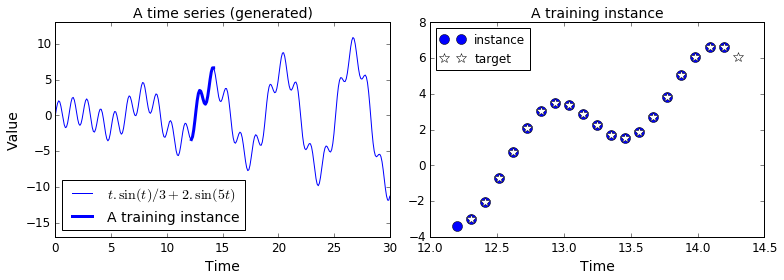

In [61]:
# np.linspace() is used to reliably produce list of numbers
# between two float values
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [62]:
X_batch, y_batch = next_batch(1, n_steps)

In [64]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

In [65]:
reset_graph()

# unroll over 20 time steps, i.e. 20 input long sequence
n_steps = 20
# each input will have just one feature (value at the time)
n_inputs = 1
n_neurons = 100
# target is to produce the next value in the sequence
n_outputs = 1



A cell wrapper acts like a normal cell, proxying every method call to an underlying cell, but it also adds some functionality. The OutputProjectionWrapper adds a fully connected layer of linear neurons (i.e., without any activation function) on top of each output (but it does not affect the cell state). All these fully connected layers share the same (trainable) weights and bias terms.
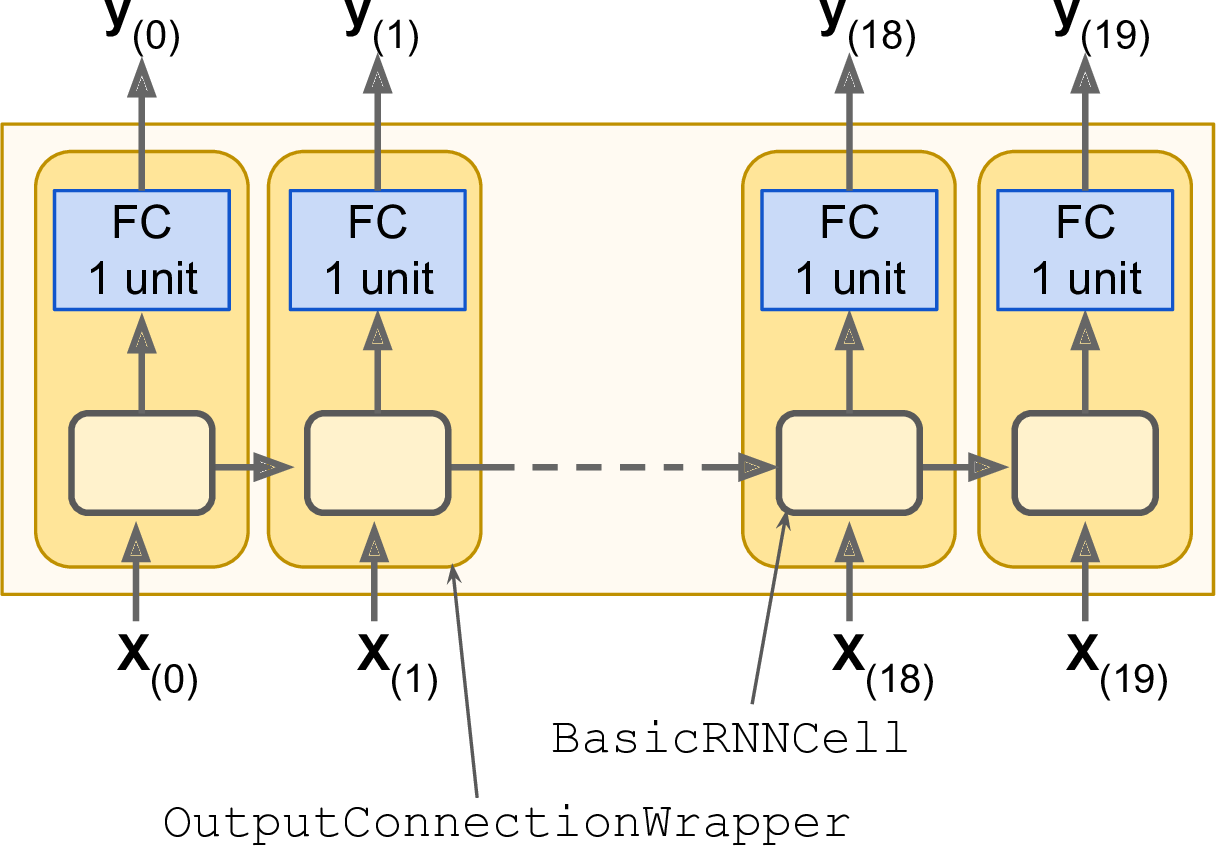

In [66]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

# cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
# output of above cell at every time step would be 100 dimension
# but we want one output
# use tf.contrib.rnn.OutputProjectionWrapper()

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                                                         activation=tf.nn.relu),
                                             output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [67]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# save the model to disk
saver = tf.train.Saver()

In [68]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./checkpoints/my_time_series_model")

0 	MSE: 13.6543
100 	MSE: 0.538247
200 	MSE: 0.168289
300 	MSE: 0.0874435
400 	MSE: 0.0629619
500 	MSE: 0.0616746
600 	MSE: 0.0564069
700 	MSE: 0.049775
800 	MSE: 0.0517765
900 	MSE: 0.0481842
1000 	MSE: 0.0482073
1100 	MSE: 0.0486998
1200 	MSE: 0.040995
1300 	MSE: 0.0480073
1400 	MSE: 0.0424012


In [69]:
with tf.Session() as sess:
    saver.restore(sess, "./checkpoints/my_time_series_model")
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

In [72]:
y_pred

array([[[-3.42513585],
        [-2.49829793],
        [-1.14639533],
        [ 0.75577426],
        [ 2.23134446],
        [ 3.06820154],
        [ 3.54994535],
        [ 3.37139535],
        [ 2.78655529],
        [ 2.17596745],
        [ 1.72463357],
        [ 1.58330703],
        [ 1.89872634],
        [ 2.77344179],
        [ 3.92580199],
        [ 5.1227541 ],
        [ 6.12859392],
        [ 6.69228935],
        [ 6.67910528],
        [ 6.10360098]]], dtype=float32)

Saving figure time_series_pred_plot


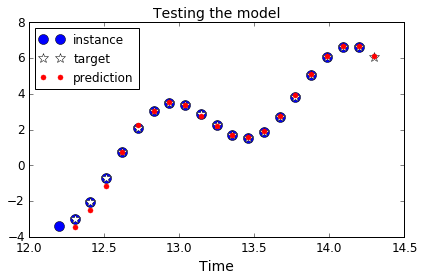

In [73]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

Although using an OutputProjectionWrapper is the simplest solution to reduce the dimensionality of the RNN’s output sequences down to just one value per time step (per instance), it is not the most efficient. There is a trickier but more efficient solution: you can reshape the RNN outputs from [batch_size, n_steps, n_neurons] to [batch_size \* n_steps, n_neurons], then apply a single fully connected layer with the appropriate output size (in our case just 1), which will result in an output tensor of shape [batch_size \* n_steps, n_outputs], and then reshape this tensor to [batch_size, n_steps, n_outputs]

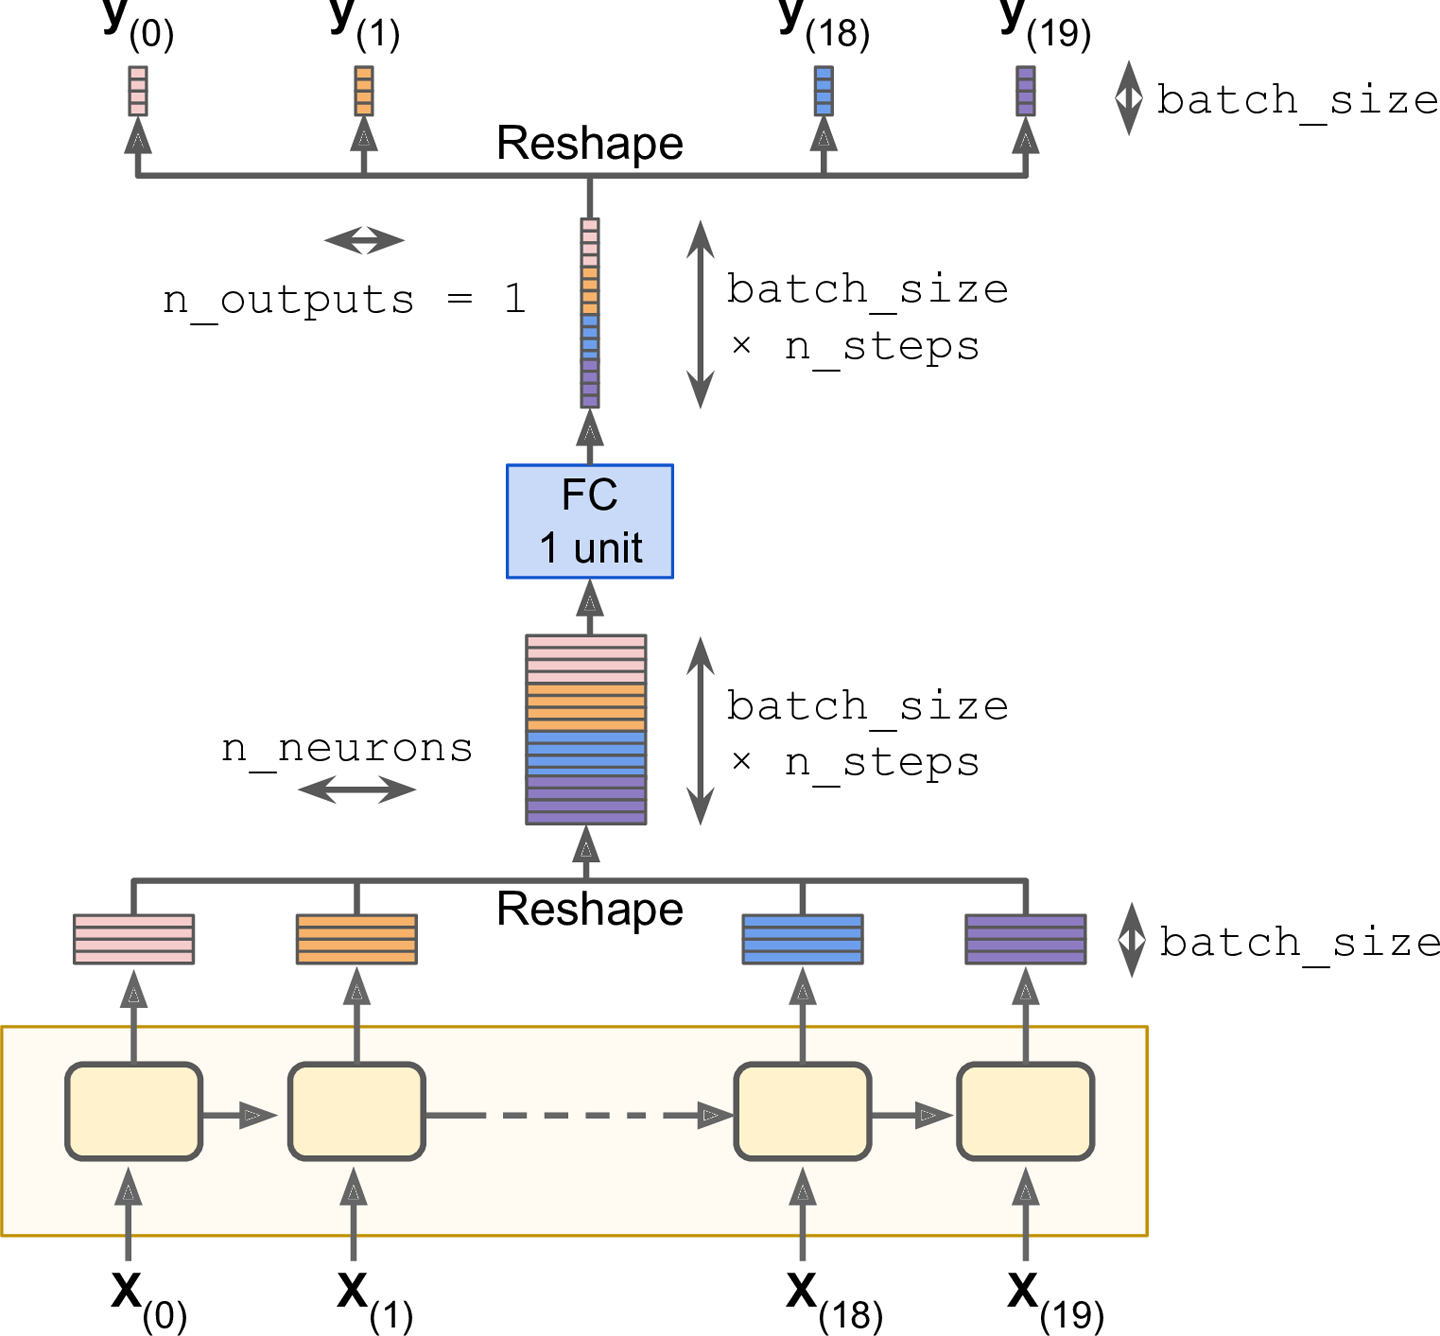

## Without using an OutputProjectionWrapper

In [74]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [75]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
# apply the fully connected linear layer (without using any activation function; this is just a projection)
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [76]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 11.6768
100 	MSE: 0.51119
200 	MSE: 0.14454
300 	MSE: 0.0757386
400 	MSE: 0.0637061
500 	MSE: 0.0603753
600 	MSE: 0.053178
700 	MSE: 0.0488119
800 	MSE: 0.0516113
900 	MSE: 0.0484619
1000 	MSE: 0.0478552
1100 	MSE: 0.0484098
1200 	MSE: 0.0419388
1300 	MSE: 0.0480069
1400 	MSE: 0.0419602


In [78]:
y_pred

array([[[-3.42065239],
        [-2.46271706],
        [-1.11927843],
        [ 0.76598269],
        [ 2.14779043],
        [ 3.14995122],
        [ 3.55193019],
        [ 3.48309135],
        [ 2.91473937],
        [ 2.24334884],
        [ 1.71404314],
        [ 1.5753355 ],
        [ 1.94827521],
        [ 2.74704885],
        [ 3.93088269],
        [ 5.19780922],
        [ 6.20094109],
        [ 6.73107481],
        [ 6.67760134],
        [ 6.09479427]]], dtype=float32)

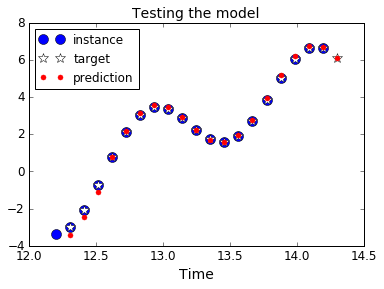

In [79]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Now that we have a model that can predict the future, we can use it to generate some creative sequences, as explained at the beginning of the chapter. All we need is to provide it a seed sequence containing n_steps values (e.g., full of zeros), use the model to predict the next value, append this predicted value to the sequence, feed the last n_steps values to the model to predict the next value, and so on. This process generates a new sequence that has some resemblance to the original time series

In [80]:
with tf.Session() as sess:                        
    saver.restore(sess, "./my_time_series_model")

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

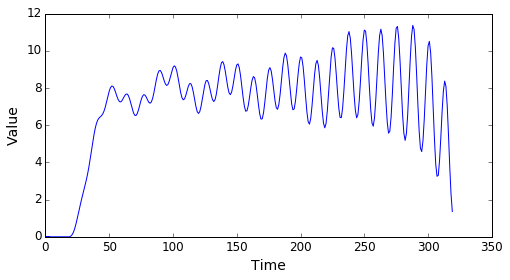

In [81]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [84]:
type(t)

numpy.ndarray

Saving figure creative_sequence_plot


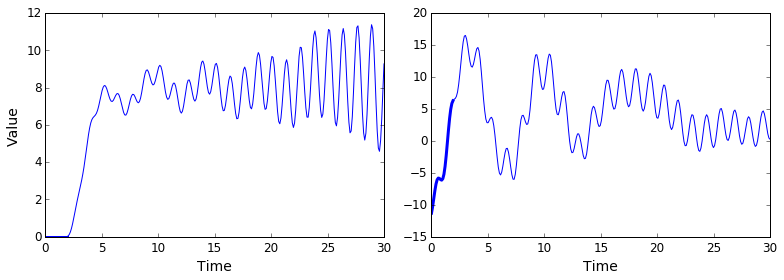

In [82]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()